In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [12]:
folder_path = "samples_data"
batch_size = 64
epochs = 160
lr = 0.001
num_layers = 3
hidden_size= 256
input_size = 2 #non si considera la y
output_size = 2 #non si considera la y
past_seconds = 2
future_seconds = 4
framerate = 10

In [13]:
class CustomDataset1(Dataset):
    def __init__(self, folder_path, past_seconds=2, future_seconds=4, framerate=10):
        self.folder_path = folder_path
        self.npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]
        self.past_frames = framerate * past_seconds
        self.future_frames = framerate * future_seconds

    def __len__(self):
        return len(self.npz_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.npz_files[idx])
        data = np.load(file_path)

        # Converte i dati in tensori PyTorch
        past_trajectory = torch.tensor(np.delete(data["past_trajectory"], 1, 1), dtype=torch.float32)
        future_trajectory = torch.tensor(np.delete(data["future_trajectory"], 1, 1), dtype=torch.float32) 

        past_trajectory = past_trajectory[:self.past_frames]
        future_trajectory = future_trajectory[:self.future_frames]

        #past_trajectory = torch.flip(past_trajectory, [0])
        
        # Normalizza i punti in modo che il punto corrente dove si trova la macchina corrisponda a (0, 0)
        '''
        shift = past_trajectory[-1, :].clone()
        past_trajectory = past_trajectory - shift
        future_trajectory = future_trajectory - shift
        '''

        return past_trajectory, future_trajectory

In [14]:
class MyGRU(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=2, num_layers=2, future_steps=40):
        super(MyGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        self.future_steps = future_steps
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, h = self.gru(x[:, :-1, :], h0) # out contiene tutti gli hidden state (dell'ultimo layer della GRU) di tutta la 
                                 # sequenza (ultimo punto escluso) # ed ha quindi dimensione [batch_size, seq_length-1,
                                 #                                                                          hidden_dim]
                                 # h contiene l'ultimo hidden state della sequenza di ogni layer della GRU, ed ha dimensione
                                 # [num_layers, batch_size, hidden_dim]
        
        future_trajectory_pred = []
        last_input = x[:, -1, :]  # ultimo punto della traiettoria passata ([batch_size, input_size])

        for _ in range(self.future_steps): 
            last_input = last_input.unsqueeze(1) #la dimensione ora è [batch_size, 1, input_size]
            out, h = self.gru(last_input, h)
            future_point = self.fc(out.squeeze(1)) # predizione punto successivo
            future_trajectory_pred.append(future_point)
            last_input = future_point # il punto successivo predetto diventa l'ultimo input
             
        return torch.stack(future_trajectory_pred, dim=1)

In [15]:
def train(model, device, train_loader, optimizer, epoch, mean_x_variance, mean_z_variance):
    model.train() # setta il modello in training mode
    lambda_x = 1./mean_x_variance
    lambda_z = 1./mean_z_variance
    train_mse_x = 0
    train_mse_z = 0
    train_mse_total = 0
    total_samples = 0

    for past, future in train_loader: # iterazione sui batch
        past, future = past.to(device), future.to(device) #spostamento traiettoria passata e futura sulla GPU
        optimizer.zero_grad() #azzera i gradienti

        future_pred = model(past) #viene eseguito il forward

        #calcolo delle loss, con la somma per normalizzare
        loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum') # MSE su x
        loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum') # MSE su z
        loss_total = lambda_x * loss_x + lambda_z * loss_z   
        
        train_mse_x += loss_x.item()
        train_mse_z += loss_z.item()
        train_mse_total += loss_total.item()

        loss_total.backward() # calcola i gradienti
        optimizer.step() # aggiorna i pesi

        total_samples += future.size(0) * future.size(1)  # numero totale di punti della traiettoria

    # normalizzazione per ottenere la media
    train_mse_x /= total_samples
    train_mse_z /= total_samples
    train_mse_total /= total_samples

    print(f'Train Epoch {epoch}: MSE Total = {train_mse_total:.6f},   MSE X = {train_mse_x:.6f},   MSE Z = {train_mse_z:.6f}')
    
    return train_mse_total, train_mse_x, train_mse_z

In [16]:
def test(model, device, test_loader, mean_x_variance, mean_z_variance):
    model.eval() #setta il modello in evaluation mode
    lambda_x = 1./mean_x_variance
    lambda_z = 1./mean_z_variance
    test_mse_x, test_mse_z, test_mse_total = 0, 0, 0
    total_samples = 0

    with torch.no_grad():
        for past, future in test_loader:
            past, future = past.to(device), future.to(device)
            future_pred = model(past)

            loss_x = F.mse_loss(future_pred[:, :, 0], future[:, :, 0], reduction='sum')  # MSE su x
            loss_z = F.mse_loss(future_pred[:, :, -1], future[:, :, -1], reduction='sum')  # MSE su z
            loss_total = lambda_x * loss_x + lambda_z * loss_z  
            
            test_mse_x += loss_x.item()
            test_mse_z += loss_z.item()
            test_mse_total += loss_total.item()

            total_samples += future.size(0) * future.size(1)

    # normalizzazione per ottenere la media
    test_mse_x /= total_samples
    test_mse_z /= total_samples
    test_mse_total /= total_samples

    print(f'Test: MSE Total = {test_mse_total:.6f},   MSE X = {test_mse_x:.6f},   MSE Z = {test_mse_z:.6f}')
    return test_mse_total, test_mse_x, test_mse_z

In [17]:
def plot_loss(epochs, train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, test_losses_z):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne

    # Plot per la loss totale
    axes[0].plot(range(1, epochs + 1), train_losses_total, marker='o', color='red', label="Train Total loss")
    axes[0].plot(range(1, epochs + 1), test_losses_total, marker='o', color='blue', label="Test Total loss")
    axes[0].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Total Loss')

    # Plot per la loss su X
    axes[1].plot(range(1, epochs + 1), train_losses_x, marker='o', color='red', label="Train X loss")
    axes[1].plot(range(1, epochs + 1), test_losses_x, marker='o', color='blue', label="Test X loss")
    axes[1].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].set_title('X Loss')

    # Plot per la loss su Z
    axes[2].plot(range(1, epochs + 1), train_losses_z, marker='o', color='red', label="Train Z loss")
    axes[2].plot(range(1, epochs + 1), test_losses_z, marker='o', color='blue', label="Test Z loss")
    axes[2].set_xticks([1] + list(range(10, epochs + 1, 10)))
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].set_title('Z Loss')

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()

In [18]:
dataset = CustomDataset1(folder_path=folder_path, past_seconds=past_seconds, future_seconds=future_seconds, 
                         framerate=framerate)
torch.manual_seed(42) # per avere lo stesso split di train/test ad ogni esecuzione
train_set, test_set = random_split(dataset, [0.75, 0.25])
train_loader = DataLoader(train_set, num_workers=2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, num_workers=2, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
all_variances_x = []
all_variances_z = []

for past, future in train_set + test_set:
    x_values = torch.cat([past[:, 0], future[:, 0]])  # estrae le coordinate x dei punti del campione
    z_values = torch.cat([past[:, 1], future[:, 1]])  # estrae le coordinate z dei punti del campione
    all_variances_x.append(torch.var(x_values))
    all_variances_z.append(torch.var(z_values))


# calcola la media delle varianze
mean_x_variance = torch.mean(torch.tensor(all_variances_x))
mean_z_variance = torch.mean(torch.tensor(all_variances_z))

print(f"Media delle varianze di x per campione: {mean_x_variance.item()}")
print(f"Media delle varianze di z per campione: {mean_z_variance.item()}")

Media delle varianze di x per campione: 0.22222653031349182
Media delle varianze di z per campione: 4.372737884521484


In [ ]:
batch = next(iter(test_loader))  # Prendi un batch dal test_loader
past_batch, future_batch = batch

for points in past_batch:
    print(points.shape)
    print(points[19])


for i in range(2):  # Plotta solo 2 esempi
    past = past_batch[i].numpy()
    future = future_batch[i].numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(past[:, 0], past[:, 1], 'go-', label='Past Trajectory')
    plt.plot(future[:, 0], future[:, 1], 'ro-', label='Future Trajectory')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title(f"Sample {i+1}")
    plt.show()

In [23]:
model = MyGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size, 
              num_layers=num_layers).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_test_loss = 1000

train_losses_x = []
train_losses_z = []
train_losses_total = []
test_losses_x = []
test_losses_z = []
test_losses_total = []

start_time = time.time()

for epoch in range(1, epochs + 1):
    #esegue un'epoca di training
    train_loss_total, train_loss_x, train_loss_z = train(model, device, train_loader, optimizer, epoch,
                                                         mean_x_variance, mean_z_variance)
    test_loss_total, test_loss_x, test_loss_z = test(model, device, test_loader, mean_x_variance, mean_z_variance)

    '''
    if(epoch!=1 and test_loss_total - test_losses_total[-1] > 0.6): 
        model.load_state_dict(best_weights)
        print(f"Early stopping applied! Got the weights of the epoch {best_epoch}")
        break
    '''

    if(test_loss_total < best_test_loss):
        best_epoch = epoch
        best_test_loss = test_loss_total
        best_weights = copy.deepcopy(model.state_dict()) 

    train_losses_total.append(train_loss_total)
    train_losses_x.append(train_loss_x)
    train_losses_z.append(train_loss_z)
    test_losses_total.append(test_loss_total)
    test_losses_x.append(test_loss_x)
    test_losses_z.append(test_loss_z)
    print("\n")

model.load_state_dict(best_weights)
print(f"Got the weights of the epoch {best_epoch}")

end_time = time.time()

execution_time = end_time - start_time

minutes, seconds = divmod(execution_time, 60) #converte il tempo in minuti e secondi

print(f"Execution time: {int(minutes)} minutes, {seconds:.2f} seconds")

Train Epoch 1: MSE Total = 2.734766,   MSE X = 0.560959,   MSE Z = 0.920456
Test: MSE Total = 2.537089,   MSE X = 0.548169,   MSE Z = 0.307727


Train Epoch 2: MSE Total = 2.333919,   MSE X = 0.493842,   MSE Z = 0.488322
Test: MSE Total = 1.847173,   MSE X = 0.388947,   MSE Z = 0.423920


Train Epoch 3: MSE Total = 1.393038,   MSE X = 0.289860,   MSE Z = 0.387829
Test: MSE Total = 1.267502,   MSE X = 0.259688,   MSE Z = 0.432586


Train Epoch 4: MSE Total = 1.313091,   MSE X = 0.273550,   MSE Z = 0.359182
Test: MSE Total = 1.239888,   MSE X = 0.259800,   MSE Z = 0.309641


Train Epoch 5: MSE Total = 1.252463,   MSE X = 0.262882,   MSE Z = 0.303983
Test: MSE Total = 1.223850,   MSE X = 0.256175,   MSE Z = 0.310828


Train Epoch 6: MSE Total = 1.195563,   MSE X = 0.251684,   MSE Z = 0.275509
Test: MSE Total = 1.315040,   MSE X = 0.276397,   MSE Z = 0.311669


Train Epoch 7: MSE Total = 1.170456,   MSE X = 0.246857,   MSE Z = 0.260716
Test: MSE Total = 1.215114,   MSE X = 0.256486,   MSE 

In [26]:
torch.save(model.state_dict(), "model_weights")

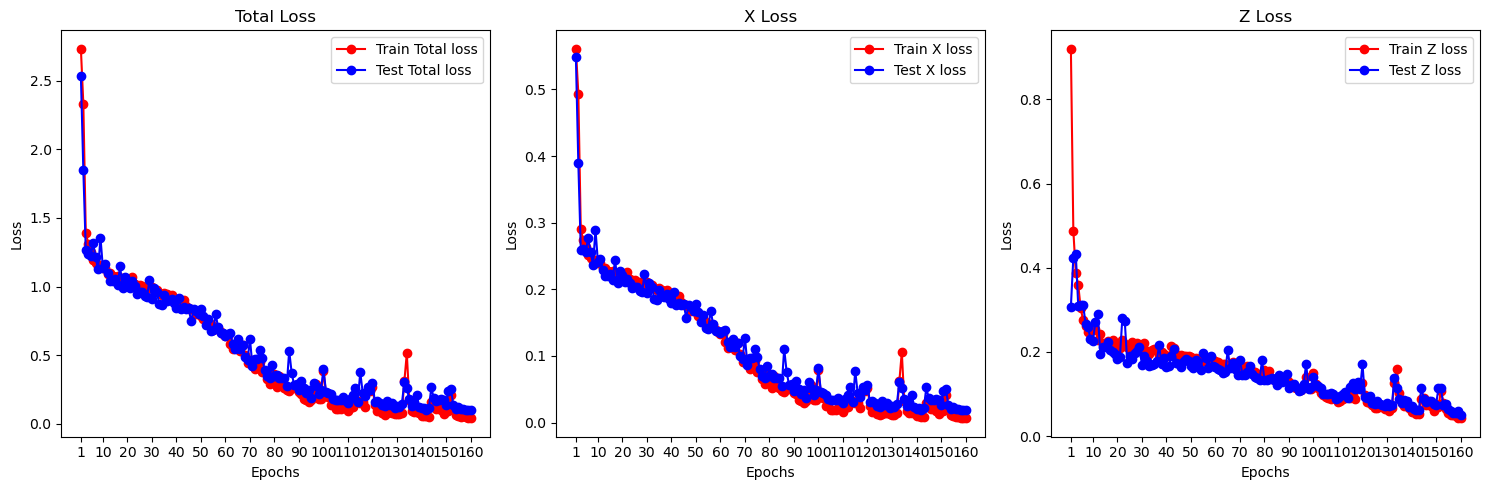

In [27]:
plot_loss(len(train_losses_total), train_losses_total, test_losses_total, train_losses_x, test_losses_x, train_losses_z, 
          test_losses_z)

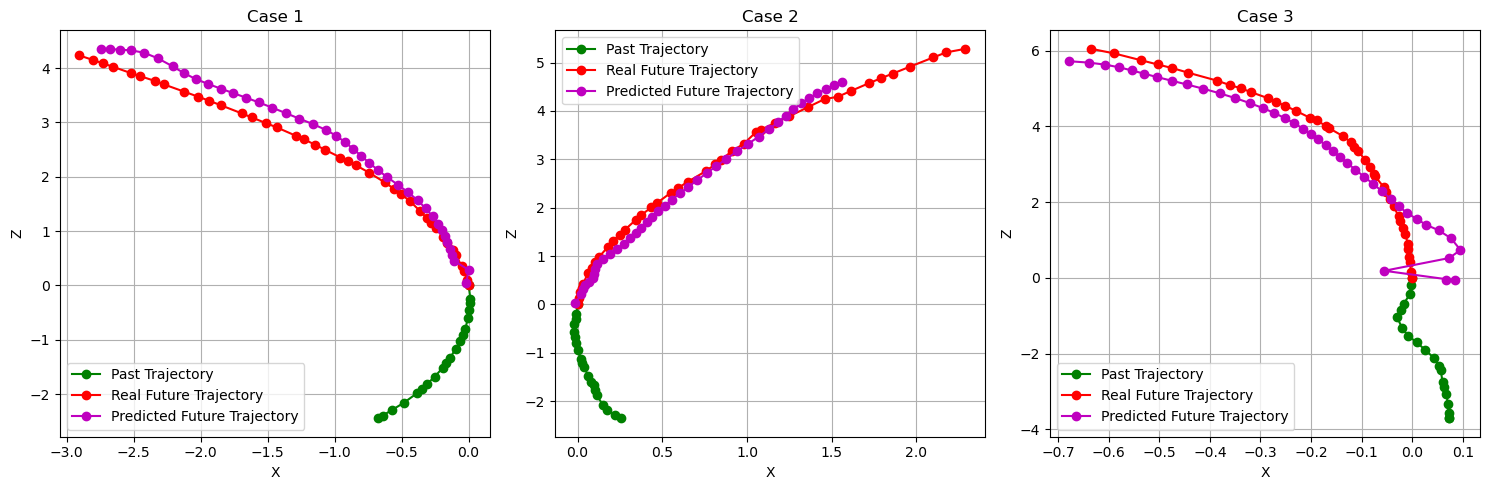

In [28]:
'''
model = MyGRU(input_size=input_size, hidden_size=hidden_size, output_size=output_size, 
              num_layers=num_layers).to(device=device)
model.load_state_dict(torch.load("model_weights"))'
'''
model.eval()
batch = next(iter(test_loader)) # prende un batch dal test_loader
past_batch, future_batch = batch  # estrae passato e futuro dal batch

# seleziona tre esempi diversi dal batch
indices = [14, 20, 32]  # indici di tre campioni
examples = [(past_batch[i], future_batch[i]) for i in indices]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (past, future) in enumerate(examples):
    past = past.cpu().numpy()
    future = future.cpu().numpy()

    # Predizione del modello
    past_tensor = past_batch[indices[i]].unsqueeze(0).to(device)  # prende un campione e aggiunge batch dim
    with torch.no_grad():
        predicted_future = model(past_tensor).squeeze(0).cpu().detach().numpy()  # predice e converte in numpy

    # Plot
    axes[i].plot(past[:, 0], past[:, 1], 'g-o', label="Past Trajectory") 
    axes[i].plot(future[:, 0], future[:, 1], 'r-o', label="Real Future Trajectory") 
    axes[i].plot(predicted_future[:, 0], predicted_future[:, 1], 'm-o', label="Predicted Future Trajectory") 
    
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Z")
    axes[i].set_title(f"Case {i+1}")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()